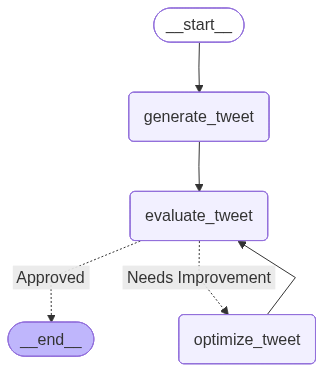

In [ ]:
from langgraph.graph import START, END, StateGraph
from typing_extensions import TypedDict
from dotenv import load_dotenv
from typing import Annotated, Literal
import operator

load_dotenv(".env")
from langchain_openai import ChatOpenAI
import os

openai_llm_model = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    api_key=os.getenv("OPENAI_API_TOKEN"),
    base_url=os.getenv("OPENAI_API_BASE"),
)
from langchain.messages import AIMessage, HumanMessage, SystemMessage


class TweetState(TypedDict):
    topic_name: str  # store the topic name
    generated_tweet: str  # store the generated tweet
    evaluation: Literal["Approved", "Needs Improvement"]
    iteration: int
    feedback: str
    max_iteration: int
    generated_tweet_history: Annotated[list[str], operator.add]
    received_feedback_history: Annotated[list[str], operator.add]


graph = StateGraph(state_schema=TweetState)


def generate_tweet(tweet_state: TweetState) -> TweetState:
    message = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer"),
        HumanMessage(
            content=f"""
        Write a a short, original and hilarious tweet on the topic {tweet_state["topic_name"]}.
        Rules:
        - Do not use the question answer format.
        - Max 280 characters.
        - Use observational humor , irony, sarcasm or cultural reference.
        - Think in meme logic or relatable takes.
        - Use simple and day to day english.
        - This is version {tweet_state["iteration"] + 1} of the tweet.
        """
        ),
    ]
    response = openai_llm_model.invoke(message)
    print("=" * 80)
    print("Generated Tweet:")
    print(response.content)
    print("=" * 80)
    return {
        "generated_tweet": response.content,
        "generated_tweet_history": [response.content],
    }


from pydantic import BaseModel, Field


class TweetEvaluation(BaseModel):
    evaluation: Literal["Approved", "Needs Improvement"] = Field(
        ..., description="Final evaluation result."
    )
    feedback: str = Field(..., description="feedback for the tweet.")


llm_evaluator = openai_llm_model.with_structured_output(TweetEvaluation)


def evaluate_tweet(tweet_state: TweetState) -> dict:
    # prompt
    messages = [
        SystemMessage(
            content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."
        ),
        HumanMessage(
            content=f"""
Evaluate the following tweet:

Tweet: "{tweet_state['generated_tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., "Masterpieces of the auntie-uncle universe" or vague summaries)

### Respond ONLY in structured format:
- evaluation: "Approved" or "Needs Improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
"""
        ),
    ]

    response = llm_evaluator.invoke(messages)
    print("=" * 80)
    print("Generated feedback:")
    print(response.evaluation, response.feedback)
    print("=" * 80)
    return {
        "evaluation": response.evaluation,
        "feedback": response.feedback,
        "received_feedback_history": [response.feedback],
    }


def optimize_tweet(tweet_state: TweetState) -> dict:
    messages = [
        SystemMessage(
            content="You punch up tweets for virality and humor based on given feedback."
        ),
        HumanMessage(
            content=f"""
Improve the tweet based on this feedback:
"{tweet_state['feedback']}"

Topic: "{tweet_state['topic_name']}"
Original Tweet:
{tweet_state['generated_tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
"""
        ),
    ]
    response = openai_llm_model.invoke(messages)
    print("=" * 80)
    print("Attempted :", tweet_state["iteration"] + 1)
    print(response.content)
    print("=" * 80)
    return {
        "generated_tweet": response.content,
        "generated_tweet_history": [response.content],
        "iteration": tweet_state["iteration"] + 1,
    }


def route_evaluation(tweet_state: TweetState) -> dict:
    if (
        tweet_state["evaluation"] == "Approved"
        or tweet_state["iteration"] == tweet_state["max_iteration"]
    ):
        return "Approved"
    else:
        return "Needs Improvement"


graph.add_node("generate_tweet", generate_tweet)
graph.add_node("evaluate_tweet", evaluate_tweet)
graph.add_node("optimize_tweet", optimize_tweet)

graph.add_edge(START, "generate_tweet")
graph.add_edge("generate_tweet", "evaluate_tweet")
graph.add_conditional_edges(
    "evaluate_tweet",
    route_evaluation,
    {"Approved": END, "Needs Improvement": "optimize_tweet"},
)
graph.add_edge("optimize_tweet", "evaluate_tweet")
tweet_generator_workflows = graph.compile()
from IPython.display import Image

Image(tweet_generator_workflows.get_graph().draw_mermaid_png())

In [ ]:
intial_state = {"topic_name": "India Railways", "iteration": 1, "max_iteration": 5}
tweet_generator_workflows.invoke(intial_state)

Generated Tweet:
"Indian Railways: where the train is always on time... in its own parallel universe. 🚂✨ #TimeTravel #IndianRailwaysLogic"
Generated feedback:
Needs Improvement The tweet attempts to humorously comment on the punctuality of Indian Railways by suggesting it operates on a different timeline, which is a common trope and lacks originality. While the concept of a 'parallel universe' adds a whimsical touch, it doesn't deliver a strong punchline or evoke a significant laugh. The use of hashtags like #TimeTravel and #IndianRailwaysLogic is appropriate for virality, but the humor doesn't quite hit the mark to make it highly shareable. The format is correct, but the joke feels like a setup-punchline, which weakens its impact.
Attempted : 2
"Indian Railways: where 'on time' is just a suggestion and every delay is a free ticket to the Twilight Zone. 🚂🌀 #TimeWarpExpress #IndianRailwaysLogic"
Generated feedback:
Needs Improvement The tweet attempts to humorously critique the punctual

{'topic_name': 'India Railways',
 'generated_tweet': '"Indian Railways: where the chai vendor knows your schedule better than the train does! 🚂☕ #ChaiChronicles #RailwayRealities"',
 'evaluation': 'Approved',
 'iteration': 5,
 'feedback': "The tweet is a clever and humorous take on the Indian Railways experience, highlighting the relatable and often amusing discrepancy between the chai vendor's punctuality and the train's schedule. It scores well on originality, as it presents a fresh perspective on a common experience. The humor is subtle yet effective, likely to resonate with those familiar with Indian train journeys. The tweet is concise and punchy, making it easy to read and share. The use of hashtags like #ChaiChronicles and #RailwayRealities adds to its virality potential by tapping into popular themes. Overall, the tweet is well-formed and avoids the pitfalls of a setup-punchline format, making it engaging and shareable.",
 'max_iteration': 5,
 'generated_tweet_history': ['"Indi